In [1]:
import os
import time

import torch
from torch import nn
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.nn import functional as F
from datetime import datetime

import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv('../kdd99/kddcup.data_10_percent_corrected')

In [3]:
df.columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'label'
]

In [4]:
# 数值列
number_col = df.select_dtypes(include=['number']).columns
# 分类变量
cat_col = df.columns.difference(number_col)
cat_col = cat_col.drop('label')
# 将分类变量筛选出来
df_cat = df[cat_col].copy()

In [5]:
# one-hot编码
one_hot_data = pd.get_dummies(df_cat, columns=cat_col)

# 将原数据的分类变量去掉
one_hot_df = pd.concat([df, one_hot_data],axis=1)
one_hot_df.drop(columns=cat_col, inplace=True)

In [6]:
minmax_scale = MinMaxScaler(feature_range=(0, 1))

def normalization(df,col):
    for i in col:
        arr = df[i]
        arr = np.array(arr)
        df[i] = minmax_scale.fit_transform(arr.reshape(len(arr),1))
    return df

In [7]:
normalized_df = normalization(one_hot_df.copy(), number_col)

In [8]:
# 为不同的类别进行编码
labels = pd.DataFrame(df.label)
label_encoder = LabelEncoder()
enc_label = labels.apply(label_encoder.fit_transform)
normalized_df.label = enc_label
label_encoder.classes_
label_num = len(label_encoder.classes_)

In [9]:
data = normalized_df

In [10]:
X = data.drop(columns=['label'])
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=50)

In [11]:
class LoadData(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        X = torch.tensor(self.X.iloc[index])
        y = torch.tensor(self.y.iloc[index])
        return X, y

In [12]:
train_data = LoadData(X_train, y_train)
test_data = LoadData(X_test, y_test)
X_dimension = len(X_train.columns)
y_dimension = len(y_train.value_counts())

In [13]:
batch_size = 128

train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [14]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [15]:
def train(model, optimizer, loss_fn, epochs):

    losses = []
    iter = 0

    for epoch in range(epochs):
        print(f"epoch {epoch+1}\n-----------------")
        for i, (X, y) in enumerate(train_dataloader):
            # print(X,y)
            X, y = X.to(device).to(torch.float32), y.to(device).to(torch.float32)
            X = X.reshape(X.shape[0], 1, X.shape[1])
            y_pred = model(X)
            loss = loss_fn(y_pred, y.long())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i % 100 == 0:
                print(f"loss: {loss.item()}\t[{(i+1)*len(X)}/{len(train_data)}]")

                iter += 1
                losses.append(loss.item())

    return losses, iter

In [16]:
def test(model):
    positive = 0
    negative = 0
    with torch.no_grad():
        iter = 0
        loss_sum = 0
        for X, y in test_dataloader:
            X, y = X.to(device).to(torch.float32), y.to(device).to(torch.float32)
            X = X.reshape(X.shape[0], 1, X.shape[1])
            y_pred = model(X)
            # print(f"y_pred: {y_pred.shape}, y: {y.shape}")
            loss = loss_fn(y_pred, y.long())
            loss_sum += loss.item()
            iter += 1
            for item in zip(y_pred, y):
                if torch.argmax(item[0]) == item[1]:
                    positive += 1
                else:
                    negative += 1
    acc = positive / (positive + negative)
    avg_loss = loss_sum / iter
    print("Accuracy:", acc)
    print("Average Loss:", avg_loss)

In [17]:
def loss_value_plot(losses, iter):
    plt.figure()
    plt.plot([i for i in range(1, iter+1)], losses)
    plt.xlabel('Iterations (×100)')
    plt.ylabel('Loss Value')

In [18]:
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.network = nn.Sequential(
            nn.Linear(X_dimension, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, y_dimension)
        )

    def forward(self, X):
        X = self.flatten(X)
        logits = self.network(X)
        return logits

In [25]:
DNN_model = DNN()
DNN_model.to(device=device)

DNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (network): Sequential(
    (0): Linear(in_features=118, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=23, bias=True)
  )
)

In [ ]:
is_trained = False
epochs = 5
lr = 1e-3
momentum = 0.9
optimizer = torch.optim.SGD(DNN_model.parameters(), lr=lr, momentum=momentum)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
path = './kdd99/'
timestamp = datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H%M%S_')
old_model_name = ''
new_model_name = timestamp + 'DNN_model.pth'

if old_model_name != '':
    DNN_model.load_state_dict(torch.load(old_model_name))
else:
    losses, iter = train(DNN_model, optimizer, loss_fn, epochs)
    torch.save(DNN_model.state_dict(), new_model_name)

    loss_value_plot(losses, iter)
    plt.savefig(path + timestamp + 'DNN_loss.png')

In [ ]:
test(DNN_model)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv1d(1, 3, kernel_size=2),
            nn.MaxPool1d(2, 2),
            nn.Conv1d(3, 8, kernel_size=2),
            nn.MaxPool1d(2, 2),
            nn.Conv1d(8, 16, kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(432, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, y_dimension)
        )

    def forward(self, X):
        X = self.backbone(X)
        X = self.flatten(X)
        logits = self.fc(X)
        return logits

In [87]:
CNN_model = CNN()
CNN_model.to(device=device)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
epochs = 5
lr = 1e-3
momentum = 0.9
optimizer = torch.optim.SGD(CNN_model.parameters(), lr=lr, momentum=momentum)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
path = './kdd99/'
timestamp = datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H%M%S_')
old_model_name = ''
new_model_name = timestamp + 'CNN_model.pth'

if old_model_name != '':
    CNN_model.load_state_dict(torch.load(old_model_name))
else:
    losses, iter = train(CNN_model, optimizer, loss_fn, epochs)
    torch.save(CNN_model.state_dict(), path + new_model_name)

    loss_value_plot(losses, iter)
    plt.savefig(path + timestamp + 'CNN_loss.png')

In [ ]:
test(CNN_model)

### resnet

In [20]:
class Residual(nn.Module): 
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv1d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv1d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv1d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm1d(num_channels)
        self.bn2 = nn.BatchNorm1d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

b1 = nn.Sequential(nn.Conv1d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm1d(64), nn.ReLU(),
                   nn.MaxPool1d(kernel_size=3, stride=2, padding=1))
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

resnet_model = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool1d((1)),
                    nn.Flatten(), nn.Linear(512, label_num))
resnet_model.to(device=device)

Sequential(
  (0): Sequential(
    (0): Conv1d(1, 64, kernel_size=(7,), stride=(2,), padding=(3,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True,

In [21]:
X = torch.rand(size=(1, 1, 224), device = device)
for layer in resnet_model:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56])
Sequential output shape:	 torch.Size([1, 64, 56])
Sequential output shape:	 torch.Size([1, 128, 28])
Sequential output shape:	 torch.Size([1, 256, 14])
Sequential output shape:	 torch.Size([1, 512, 7])
AdaptiveAvgPool1d output shape:	 torch.Size([1, 512, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 23])


In [22]:
is_trained = False
epochs = 5
lr = 1e-3 
momentum = 0.9
optimizer = torch.optim.SGD(resnet_model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

epoch 1
-----------------
loss: 2.7919507026672363	[128/395216]
loss: 0.10325092077255249	[12928/395216]
loss: 0.12122007459402084	[25728/395216]
loss: 0.06511908769607544	[38528/395216]
loss: 0.07444724440574646	[51328/395216]
loss: 0.04308005049824715	[64128/395216]
loss: 0.07678329199552536	[76928/395216]
loss: 0.021738100796937943	[89728/395216]
loss: 0.07202157378196716	[102528/395216]
loss: 0.013766096904873848	[115328/395216]
loss: 0.018277285620570183	[128128/395216]
loss: 0.03003612719476223	[140928/395216]
loss: 0.011348562315106392	[153728/395216]
loss: 0.005721363704651594	[166528/395216]
loss: 0.012138902209699154	[179328/395216]
loss: 0.0050987065769732	[192128/395216]
loss: 0.005431415978819132	[204928/395216]
loss: 0.003758478444069624	[217728/395216]
loss: 0.019388873130083084	[230528/395216]
loss: 0.011002158746123314	[243328/395216]
loss: 0.011393379420042038	[256128/395216]
loss: 0.005530799273401499	[268928/395216]
loss: 0.02788977324962616	[281728/395216]
loss: 0.

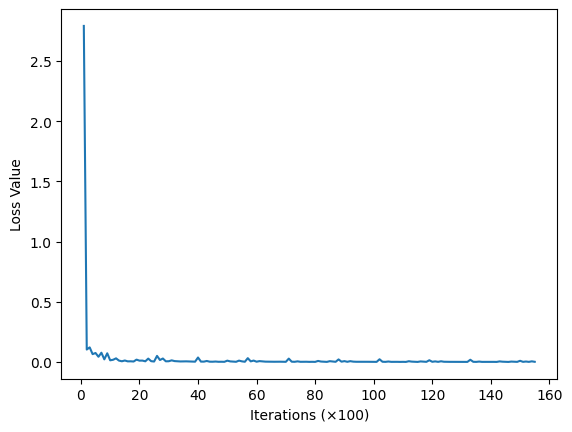

In [23]:
path = './kdd99/'
timestamp = datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H%M%S_')
old_model_name = ''
new_model_name = timestamp + 'resnet_model.pth'

if old_model_name != '':
    resnet_model.load_state_dict(torch.load(old_model_name))
else:
    losses, iter = train(resnet_model, optimizer, loss_fn, epochs)
    torch.save(resnet_model.state_dict(), path + new_model_name)

    loss_value_plot(losses, iter)
    plt.savefig(path + timestamp + 'resnet_loss.png')

In [24]:
test(resnet_model)

Accuracy: 0.9992308003724546
Average Loss: 0.004080249528269256
